In [1]:
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
# join with animal df to get calving date
# dir = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir),"udder_processing",  "udder_features")
animaldf = pd.read_csv("animal_info.csv", sep = ";")
animaldf.columns = [col.replace(" ", "_").lower().replace("-", "") for col in animaldf.columns]
fresh_dates = animaldf[["animal_number", "last_calving_date", "lactation_number"]]
fresh_dates["fresh_date"] = pd.to_datetime(fresh_dates["last_calving_date"], format = '%m/%d/%Y')
fresh_dates = fresh_dates[~fresh_dates.fresh_date.isnull()]
fresh_dates = fresh_dates.drop("last_calving_date", axis = 1)
# filter records only on current lactation 
# get kickoffs current lactation per quarter

C:\Users\marie\AppData\Local\Temp\ipykernel_28984\1852963493.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fresh_dates["fresh_date"] = pd.to_datetime(fresh_dates["last_calving_date"], format = '%m/%d/%Y')


In [32]:
# filter records only on current lactation
df = pd.read_csv(r"kick_offs\kick_offs_year.csv", sep = ";")
df.columns = [col.replace(" ", "_").lower().replace("-", "") for col in df.columns]

# [re.findall("U", val) for val in df.kickoff_lr]
df["ko_lr"] = [0 if "U" in val else 1 for val in df.kickoff_lr]
df["ko_lf"] = [0 if "U" in val else 1 for val in df.kickoff_lf]
df["ko_rf"] = [0 if "U" in val else 1 for val in df.kickoff_rf]
df["ko_rr"] = [0 if "U" in val else 1 for val in df.kickoff_rr]

df = df.drop(["kickoff_rf", "kickoff_lf", "kickoff_lr", "kickoff_rr"], axis = 1)

df["date"] = pd.to_datetime(df["date"], format = '%m/%d/%Y')
merged_df =  pd.merge(fresh_dates, df,  left_on="animal_number", right_on = "animal_number")

merged_df["dim"] = (merged_df["date"] - merged_df["fresh_date"]).dt.days
merged_df["total"] = merged_df["ko_lf"] + merged_df["ko_rf"] + merged_df["ko_rr"]+ merged_df["ko_lr"]
merged_df = merged_df[merged_df.dim >= 0]

In [33]:
ko_df = merged_df.groupby(["animal_number", "lactation_number"])[["ko_lr","ko_lf", "ko_rf","ko_rr"]].agg("sum").reset_index()
dim_df =  merged_df.groupby("animal_number")[["dim"]].agg(["max", "count"]).droplevel(axis=1, level=0).reset_index()
ko_df2 = pd.merge(ko_df, dim_df,  left_on="animal_number", right_on = "animal_number")
ko_df2["total"] = ko_df2.ko_rr + ko_df2.ko_rf +ko_df2.ko_lr + ko_df2.ko_lf
ko_df2.to_csv("kick_offs_current_lactaion.csv", index = False)

In [34]:
kickers = ko_df2[ko_df2.total > 0]

<Axes: xlabel='lactation_number', ylabel='total'>

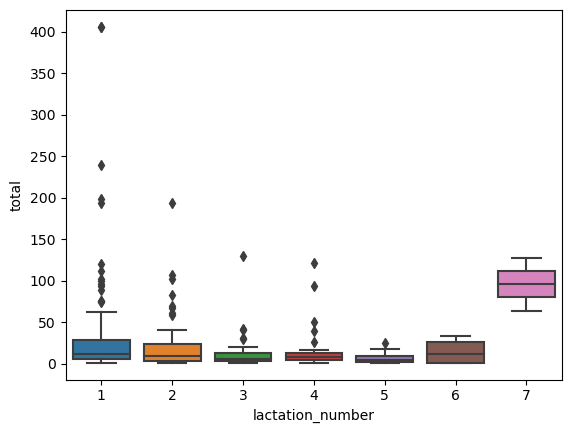

In [35]:
sns.boxplot(x = kickers.lactation_number, y = kickers.total)

<Axes: xlabel='dim', ylabel='total'>

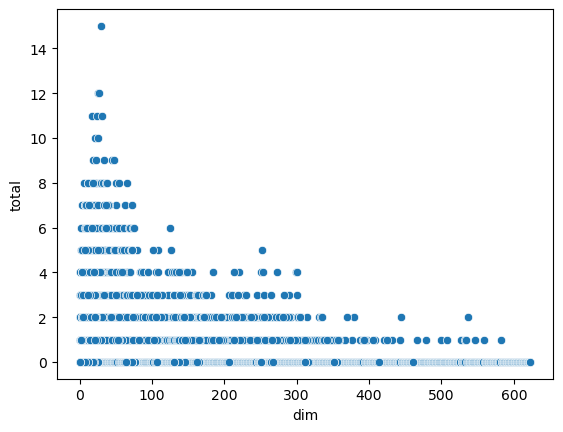

In [36]:
# kickofs by days in milk
merged_df2 = merged_df.groupby(["animal_number","dim"])["total"].agg("sum").reset_index()
sns.scatterplot(x = "dim", y = "total", data = merged_df2)

In [37]:
kick_ids = np.unique(kickers.sort_values(by = "total").animal_number)

In [38]:
more_kicks = merged_df2[merged_df2.animal_number.isin(kick_ids[:10])]
more_kicks.animal_number = [ str(cow) for cow in more_kicks.animal_number]

C:\Users\marie\AppData\Local\Temp\ipykernel_28984\1469002646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  more_kicks.animal_number = [ str(cow) for cow in more_kicks.animal_number]


In [31]:
more_kicks

,animal_number,dim,total
0,254,5,0
1,254,6,1
2,254,7,1
3,254,8,0
4,254,9,1
...,...,...,...
2239,729,166,0
2240,729,167,0
2241,729,168,0
2242,729,169,0


<Axes: xlabel='dim', ylabel='total'>

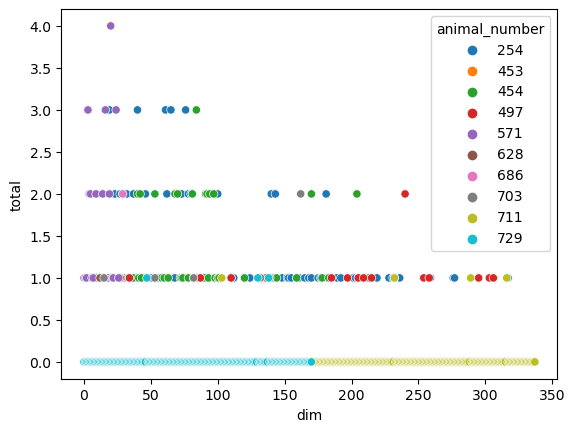

In [39]:
sns.scatterplot(x = "dim", y = "total", data = more_kicks, hue = "animal_number")